# Implementando un autoencoder variacional

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_2/notebooks/Nb_2e_variational_mlp_autoencoders.ipynb)

In [ ]:
#@title Importar librerías
#importar librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
#@title Funciones complementarias

# Visualización del espacio latente 2D ---
# Esto solo funciona con un latent_dim de 2

def plot_latent_space(vae, n=30, figsize=15):
    # Genera puntos en una cuadrícula
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    figure = np.zeros((img_dim * n, img_dim * n))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(img_dim, img_dim)
            figure[
                i * img_dim : (i + 1) * img_dim,
                j * img_dim : (j + 1) * img_dim,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# Visualización de las reconstrucciones
def plot_reconstructions(vae, data, n=10):
    reconstructions = vae.decoder.predict(vae.encoder.predict(data)[2])

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Imágenes originales
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(img_dim, img_dim), cmap="Greys_r")
        plt.axis("off")

        # Imágenes reconstruidas
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].reshape(img_dim, img_dim), cmap="Greys_r")
        plt.axis("off")
    plt.show()

# Modelos generativos

Ahora, consideremos que no solo queremos aprender la distribución subyacente de los datos para hacer clasificación sobre datos no vistos (evaluar la probabilidad de que una nueva imagen sea o no un digito), sino que queremos generar muestras de (muestrear) dicha distribución. Es decir, queremos generar imágenes que sean muy parecidas a estos digitos, imágenes que no han sido vistas antes en el proceso de entrenamiento. Para esta nuevo problema, los modelos predictivos son útiles para indicar que tan parecida es una imágen a un digito no son necesariamente útiles para sintetizar imágenes de digitos.

Si nuestros datos x (en la base de datos X) se distribuyen de acuerdo a la distribución verdadera P(x), el próposito es ahora, estimar una distribución (z)
que podamos muestrear y que sea lo mas similar posible a P(x).

# Dataset MNIST (Generación de imagenes)

El ejemplo que usaremos es el de generar imágenes de dígitos manuscrito a partir de los ejemplos en la BD MNIST.

La idea clave en los autoencoders variacionales es que nuestros datos, aunque sean de muy altas dimensiones (28×28=784 pixeles), en realidad “viven” en un espacio de baja dimensión el cual es parametrizado por el vector z; que, como digimos, es de baja dimensión. Este vector  z es la variable latente y codifica la información para generar las imágenes. Variando z generamos los distintos dígitos con sus distintos estilos.

Este dataset puede ser descargado de diversas fuentes incluido keras.

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

img_dim = x_train.shape[1]    # tamano de la imagen 28
original_dim = img_dim * img_dim # dimension original

# no necesito datos de test por lo que combino test y train
mnist_digits = np.concatenate([x_train, x_test], axis=0)
#normalizo mis datos
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255.0

# Aplanamos las imágenes para las capas densas
mnist_digits = np.reshape(mnist_digits, (len(mnist_digits), original_dim))

In [ ]:
print("Numero de datos para train: ", mnist_digits.shape)

Numero de datos para train:  (70000, 784)


# Definicion de hiperparametros

In [ ]:
epochs       = 20        # número de epocas
batch_size   = 128      # tamaño del lote
latent_dim   = 2        # número de parámetros del espacio latente

En general queremos implementar la siguiente arquitectura:
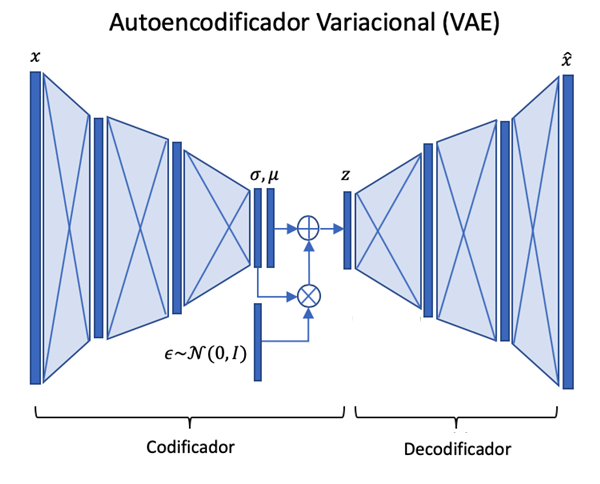

En la figura de arriba se aprecia que el codificador "codifica" $\mathbf{x}$ en $\mathbf{z}$ en una distribución gausiana con los parametros $\mu$ y $\sigma$ y el decodificador "decodifica" $\mathbf{z}$ en $\hat{\mathbf{x}}$ su distribución original. También se aprecia como $\mu(\mathbf{x})$ y $\sigma(\mathbf{x})$ (los parametros de la distribición $\mathbf{p(z)}$ se obtienen mediante una DNN determinística y que $\mathbf{z}$ se obtiene mediante el "truco de la reparametrización". Cuando la red se entrena en forma completa, tanto la propagación hacia adelante como la retropropagación (para calcular el gradiente) se hace a través de capas determinísticas y continuas sobre los parámetros de $Q_{\theta}(\mathbf{z}|\mathbf{x})$, $P_{\theta}(\mathbf{z})$ y $P_{\theta}(\mathbf{x}|\mathbf{z})$.

## Función de muestreo del espacio latente

Recordemos que p(z) es una distribución y para poder muestrear datos de ella debemos hacerlo usando la técnica de reparametrización que es tomar datos aleatorios de una función normal y luego usar los parámetros $\mu$ y $\sigma$ de p(z) para muestrear datos que siguen la distribución p(z) sin introducir este termino aleatorio a la red. La formula es:

$y = \mu + \sigma \epsilon, \quad \text{donde} \quad \epsilon \sim \mathcal{N}(0, I)$


In [ ]:
class Sampling(layers.Layer):
    """
    Capa que utiliza (z_mean, z_log_var) para muestrear z, el vector de codificación.
    """
    def call(self, inputs):
        #obtener lo media y la varianza de p(z)
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # tomar datos alatorios de la distribucion normal del tamano del batch y el
        # espacio latente
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        #aplicar reparametrizacion
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Codificador (encoder)

Una vez que tenemos la media y la log-varianzas generamos la muestra para enviarla al decodificador.

Esta operación la implementamos mediante una capa especial de Keras, la capa Lambda (que nos recuerda las funciones lambda de python).

simplemente Lambda va a aplicar una función (la función de reparametrización) a cada uno de mis datos z

In [ ]:
# capa de entrada (datos) al decodificador
encoder_inputs = keras.Input(shape=(original_dim,))
# capas intermendias
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)
# media y log-varianza del espacio latente
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# muestreo de z con el truco de la reparametrizacion
z = Sampling()([z_mean, z_log_var])
# Modelo del "encoder" las salidas son: media, log-varianza y muestra
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 234,372 (915.52 KB)

 Trainable params: 234,372 (915.52 KB)

 Non-trainable params: 0 (0.00 B)

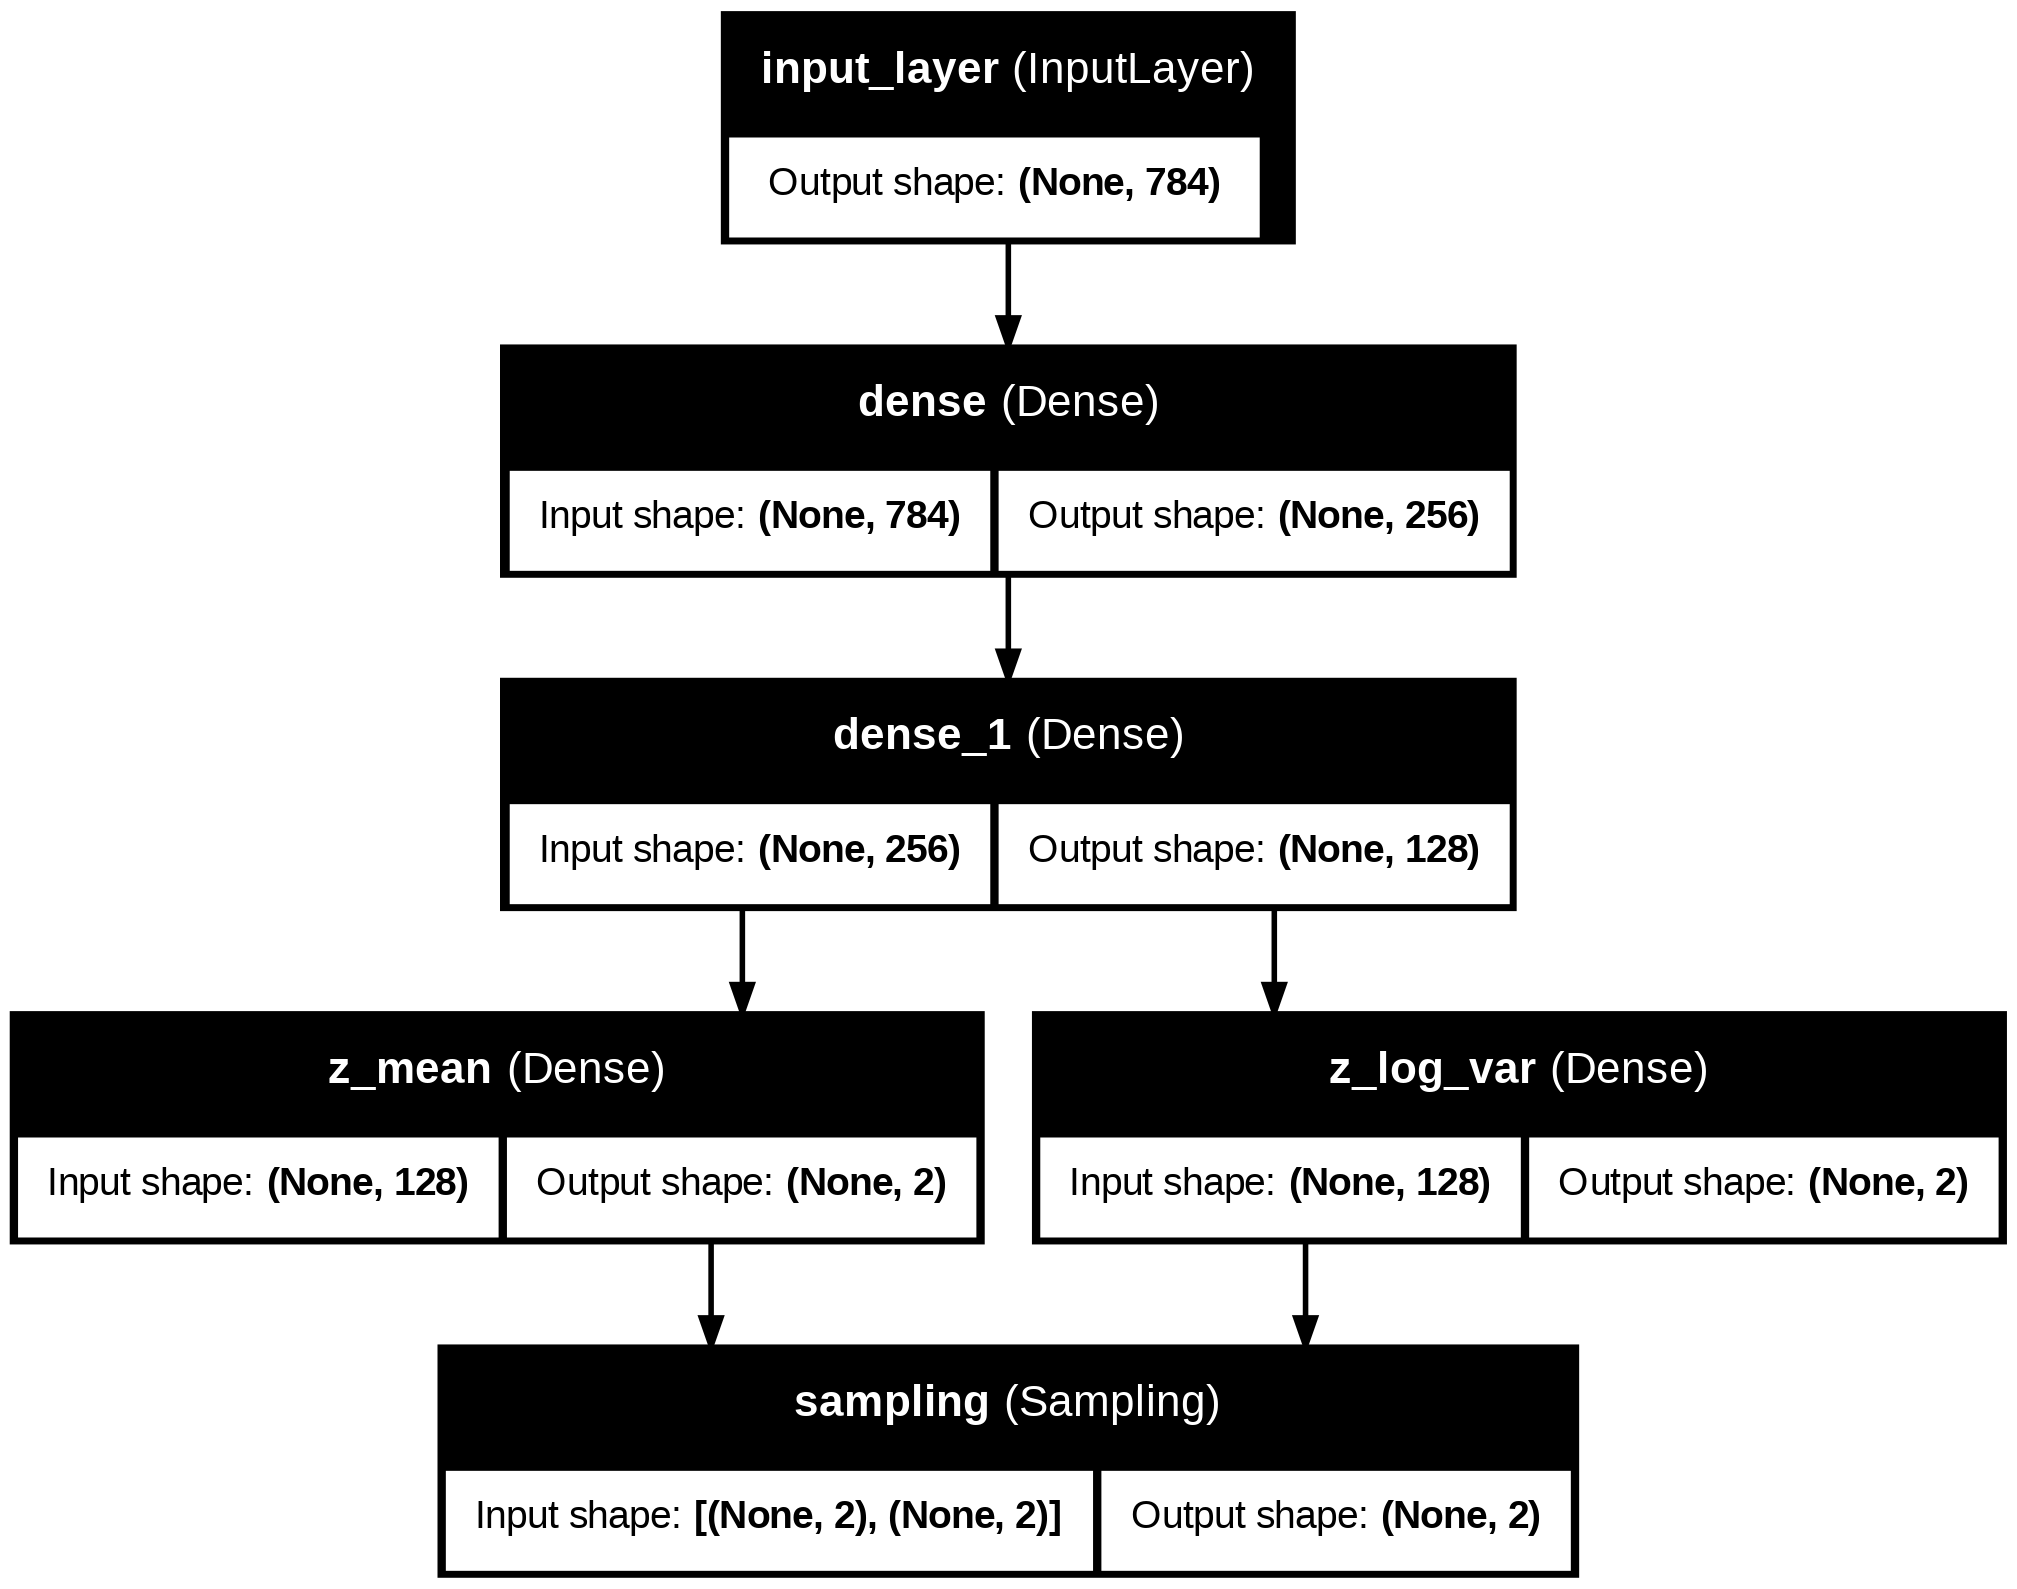

In [ ]:
### Visualización del Codificador

plot_model(encoder, to_file='model_encoder.png',show_shapes=True, show_layer_names=True)

## Decodificador (decoder)

In [ ]:
# capa de entrada (datos) al decodificador
latent_inputs = keras.Input(shape=(latent_dim,))
# capas intermedias
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
# capa de salida con dimensiones igual a las orginales
decoder_outputs = layers.Dense(original_dim, activation="sigmoid")(x)
# definición del modelo del decodificador
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,896 (917.56 KB)

 Trainable params: 234,896 (917.56 KB)

 Non-trainable params: 0 (0.00 B)

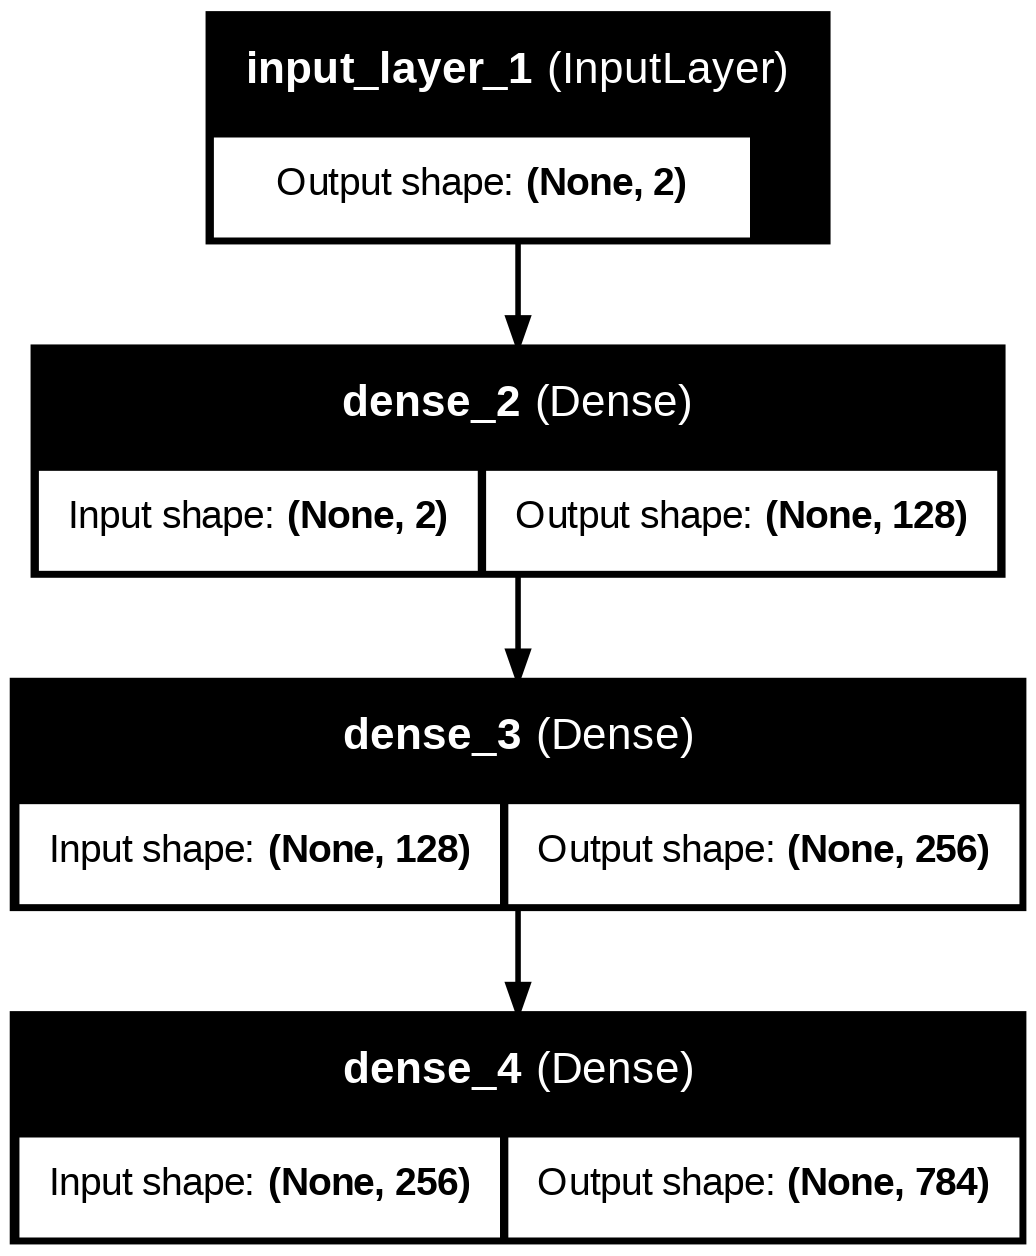

In [ ]:
plot_model(decoder, to_file='model_decoder.png',show_shapes=True, show_layer_names=True)

# Definición del VAE como un modelo de Keras con un custom train_step

## Función de pérdida para el VAE

Como vimos en la derivación, la función de pérdida usada en autencoders variacionales es una combinación de la entropía cruzada binaria $\mathbb{E}_{z \sim Q} \left\{log P(\mathbf{x} | \mathbf{z}) \right\}$ y la Divergencia de Kullback-Leibler $D\left[ Q(\mathbf{z}|\mathbf{x}) \| P(\mathbf{z}) \right]$.

$ L = D\left[ Q(\mathbf{z}|\mathbf{x}) \| P(\mathbf{z}) \right] + \mathbb{E}_{z \sim Q} \left\{log P(\mathbf{x} | \mathbf{z}) \right\}$


$D\left[ Q(\mathbf{z}|\mathbf{x}) \| P(\mathbf{z}) \right] = \frac{1}{2} \sum_i \left[ \sigma_{x_i}^{2} + \mu_{x_i}^{2} - 1 - \log \sigma_{x_i}^{2} \right]$

y


$\mathbb{E}_{z \sim Q} \left\{log P(\mathbf{x} | \mathbf{z}) \right\} = \sum_i \left[ x_{i}log(\hat{x_i}) + (1 - x_{i})log(1 - \hat{x_i}) \right]$

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        # heredo todo de keras.model
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # defino las variables de mis metricas a seguir
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.logP_loss_tracker = keras.metrics.Mean(name="logP_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # incluyo mis metricas a mi modelo
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.logP_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # GradientTape: Su función principal es grabar las operaciones para el cálculo automático de gradientes.
        with tf.GradientTape() as tape:
            # obtengo mi media, varianza y mis muestras (espacio latente) del encoder
            z_mean, z_log_var, z = self.encoder(data)
            # le paso las muestras a el decoder
            reconstruction = self.decoder(z)

            # Cálculo de las pérdidas (pérdida de logP y pérdida KL)
            # calculo la CE para todos los datos
            logP_loss = tf.reduce_mean(tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)))
            # calculo la perdida KL para todos mis datos
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = logP_loss + kl_loss

        # basados en mi perdida obtengo mis gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)
        # realizo el backpropagation
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # actualizo mis metricas
        self.total_loss_tracker.update_state(total_loss)
        self.logP_loss_tracker.update_state(logP_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "logP": self.logP_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# creo mi modelo y defino todos mis hyperparametros
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=epochs, batch_size=batch_size)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 1.4267 - logP: 38.9477 - loss: 40.3744
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 2.0056 - logP: 28.7408 - loss: 30.7464
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 2.3839 - logP: 27.6377 - loss: 30.0217
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 2.6047 - logP: 27.0814 - loss: 29.6861
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 2.7759 - logP: 26.5854 - loss: 29.3613
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 2.9772 - logP: 26.0999 - loss: 29.0772
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.1156 - logP: 25.7614 - loss: 28.8770
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 3.2373 - logP: 25.4942 - loss: 28.7316
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.3274 - logP: 25.2123 - loss: 28.5397
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.4117 - logP: 25.

## Espacio latente

para generar el espacio latente vamos a generar diferentes imagenes variando poco a poco sus valores  $\mu$ y $\sigma$

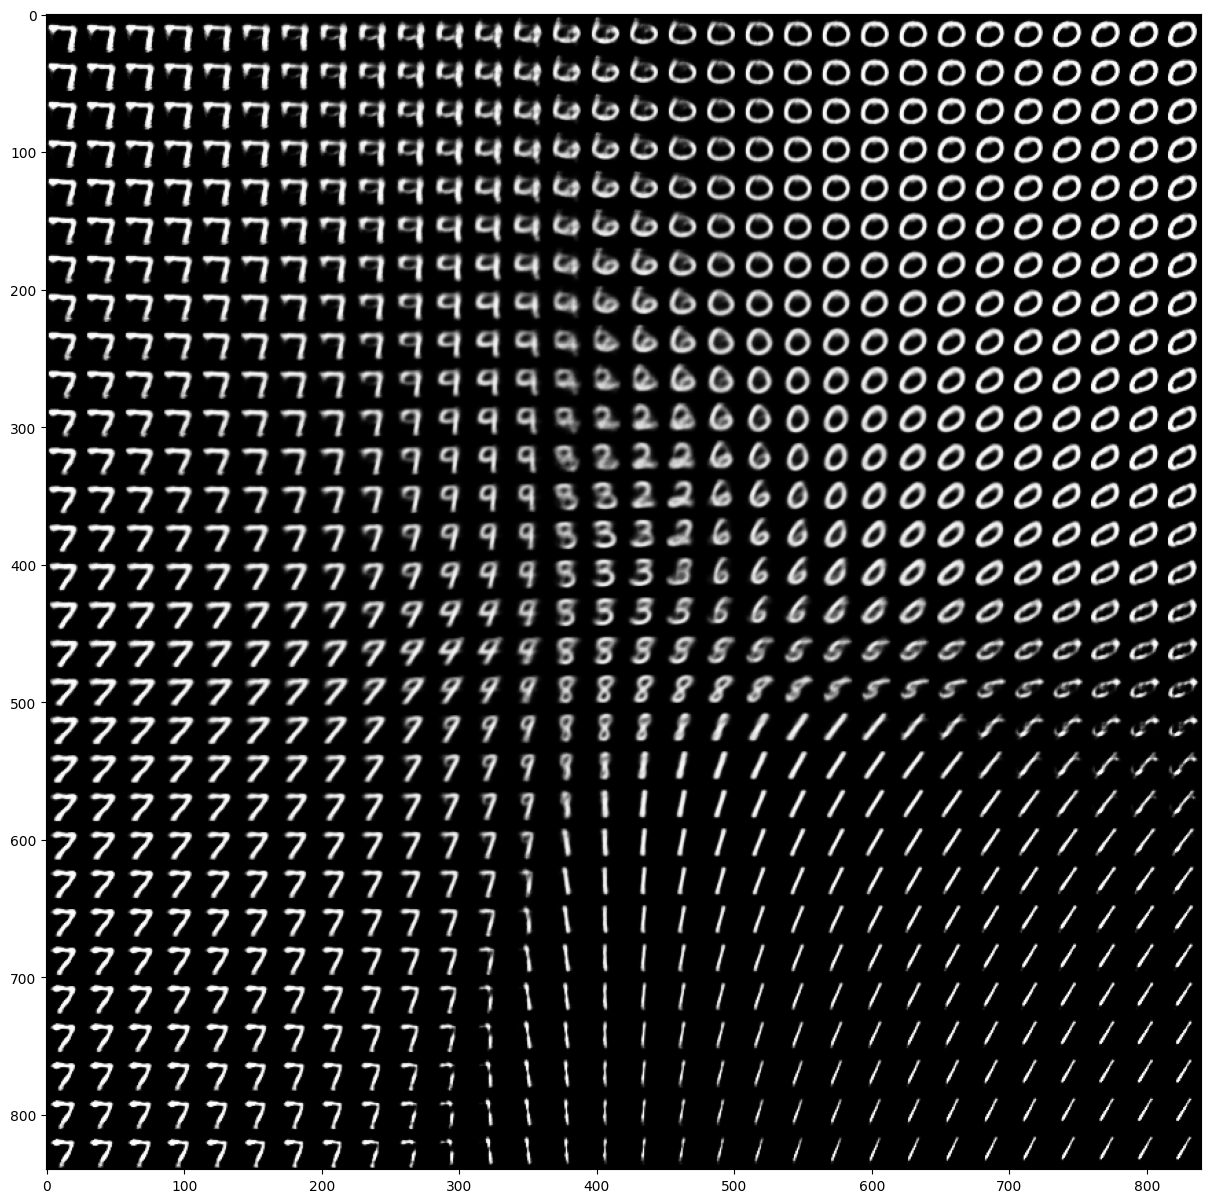

In [ ]:
plot_latent_space(vae)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


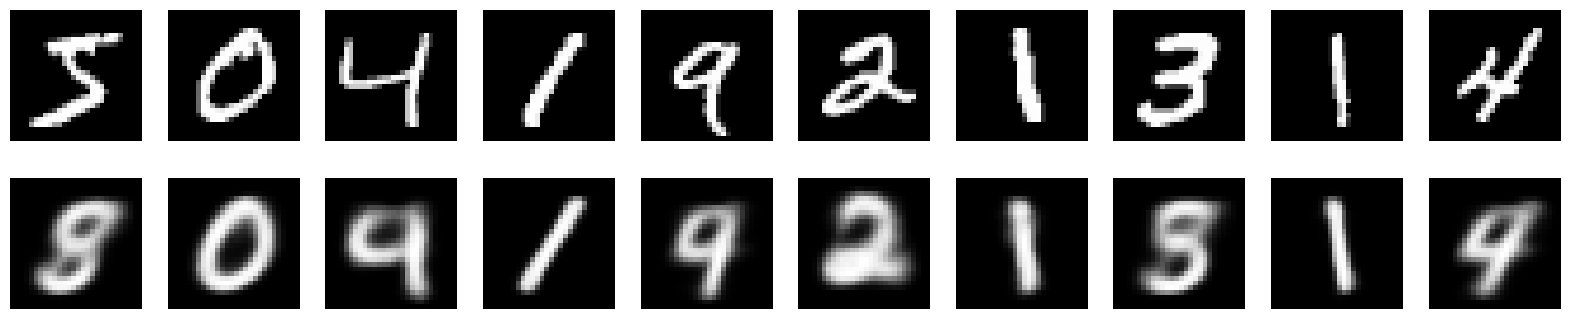

In [ ]:
test_data = mnist_digits[0:10]
plot_reconstructions(vae, test_data)